In [1]:
import numpy as np
import os
import random


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes
import seaborn as sns
from matplotlib.patches import Ellipse

import matplotlib.transforms as transforms

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)

from plotting_tools import set_layout
from statistical_analysis import comparison_distributions
from plotting_tools import save_figures

In [13]:
#function to visualize confidence_ellipses on plots. Taken from <WEBSITE LINK>

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## PROCESS CT AND NETWORK PARAMETERS

Statistical analysis to extract any statistical difference between curaxin treated and control samples.
Pick resolution and quantile threshold for the analysis

In [ ]:
set_layout(18,18,18)

In [2]:
quantile_thresh = 0.992
resolution = '20'
path_data = 'results'
path_figures = f'{path_data}/figures/{resolution}'

- Load processed data (data produced by ExtractTopology_Cyraxin notebook or curaxin_allres.py)
- Combine all data in one dataframe
- Add extra columns: normalized fractal dimension, entangled fraction

In [5]:
control1 = pd.read_feather(f'{path_data}/processed_Control1_{resolution}_{quantile_thresh}.feather')
control1['Sample'] = ['Control 1']*len(control1)
control1['Specimen'] = ['Control']*len(control1)
control2 = pd.read_feather(f'{path_data}/processed_Control2_{resolution}_{quantile_thresh}.feather')
control2['Sample'] = ['Control 2']*len(control2)
control2['Specimen'] = ['Control']*len(control2)
treated1 = pd.read_feather(f'{path_data}/processed_Treated1_{resolution}_{quantile_thresh}.feather')
treated1['Sample'] = ['Treated 1']*len(treated1)
treated1['Specimen'] = ['Curaxin']*len(treated1)
treated2 = pd.read_feather(f'{path_data}/processed_Treated2_{resolution}_{quantile_thresh}.feather')
treated2['Sample'] = ['Treated 2']*len(treated2)
treated2['Specimen'] = ['Curaxin']*len(treated2)

frames = [control1, control2, treated1, treated2]
data = pd.concat(frames)

data['Norm dim'] = data['Fractal dimension']/data['N contacts']
data['Entangled fraction (%)'] = data['Cross (%)'] + data['Parallel (%)']

data = data.reset_index()

### Barplot
Pick the parameter you want to visualize, adjust y axis limits

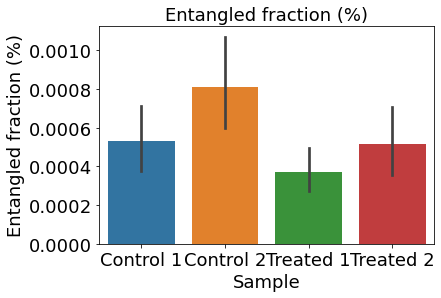

In [6]:
parameter = 'Entangled fraction (%)'

a = plt.figure()
plt.title(parameter)
sns.barplot(x = 'Sample', y = parameter,data = data )
#plt.legend(bbox_to_anchor=(1, 1)) 
#plt.ylim(1.10, 1.2)

save_figures(plot = a,path = path_figures, name_file = parameter, method= quantile_thresh)

### Histplot
Pick the parameter you want to visualize, adjust binning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


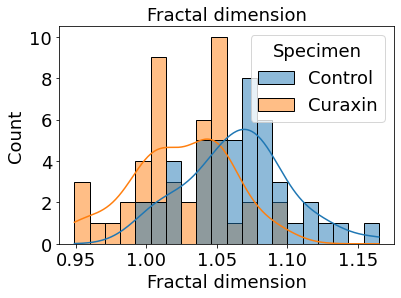

In [7]:
a = plt.figure()
parameter = 'Fractal dimension'
plt.title(parameter)
sns.histplot( x= parameter, hue = 'Specimen', data = data, bins = 20, kde = True)
save_figures(plot = a,path = path_figures, name_file = f'dist_{parameter}', method= quantile_thresh)  

### Calculate p values associated to parameter distributions for the 4 samples
Choose the parameter you want to analyze

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Control 1, Control 2
the distributions are not normal: 0.0001565087295603007, 0.00014960113912820816
The distributions have equal variance: 0.3423334583230887
Mannwhitneyu test: False = 0.022324864059816762
Control 1, Treated 1
the distributions are not normal: 0.0001565087295603007, 0.00026980822440236807
The distributions have equal variance: 0.32233967818029624
Mannwhitneyu test: True = 0.09071713374520807
Control 1, Treated 2
the distributions are not normal: 0.0001565087295603007, 8.061299740802497e-05
The distributions have equal variance: 0.9025741759590843
Mannwhitneyu test: True = 0.6763753016299376
Control 2, Control 1
the distributions are not normal: 0.00014960113912820816, 0.0001565087295603007
The distributions have equal variance: 0.3423334583230887
Mannwhitneyu test: False = 0.022324864059816762
Control 2, Treated 1
the distributions are not normal: 0.00014960113912820816, 0.00026980822440236807
The distributions have equal variance: 0.0747581217305185
Mannwhitneyu test

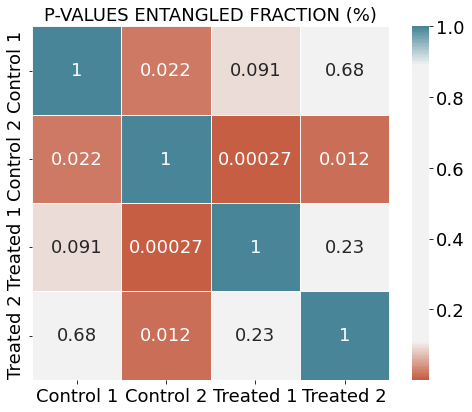

In [8]:
quantity = 'Entangled fraction (%)'

samples = ['Control 1', 'Control 2', 'Treated 1', 'Treated 2']
p_values_matrix = np.ones((len(samples), len(samples)))
p_values = {}

for ind1, sample1 in enumerate(samples):
    for ind2, sample2 in enumerate(samples):
        if (sample1 != sample2):
            
            dist1 = data[data['Sample'] == sample1 ][quantity]
            dist2 = data[data['Sample'] == sample2 ][quantity]
            print(f'{sample1}, {sample2}')
            stats = comparison_distributions(dist1, dist2)
            p_value = float(stats[-1])
            key = tuple[sample1, sample2]
            p_values[key] = p_value
            p_values_matrix[ind1, ind2] = p_value
            
            
cmap = sns.diverging_palette(220, 20, sep=200, as_cmap=True).reversed()
label = []

a = plt.figure(figsize = (8, 6.5))
plt.title(f'P-values {quantity}'.upper())
sns.heatmap(p_values_matrix, xticklabels = samples, yticklabels = samples, annot = True, cmap = cmap, linewidths=1, 
            linecolor='white', alpha = 0.95)        
        
    
save_figures(plot = a,path = path_figures, name_file = f'p_values_{quantity}', method= quantile_thresh)    

## Barplot: chromosome hues
Visualize bar for each chromosome. Adjust y axis limits.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


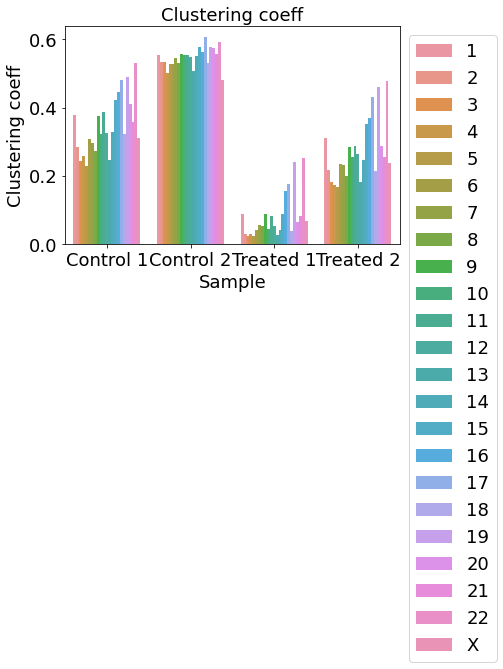

In [10]:
parameter = 'Clustering coeff'
set_layout(18,18,18)
a = plt.figure()
sns.barplot(x = 'Sample', y = parameter, hue = 'Chromosome', data = data )
#plt.ylim(0.65, 0.78)
plt.title(parameter)
plt.legend(bbox_to_anchor=(1, 1))  
save_figures(plot = a,path = path_figures, name_file = f'chromosomes_{parameter}', method= quantile_thresh)  

### Scatterplot
Visualize each sample in the fractal dimension/ clustering coefficient plane

Text(0.5, 1.0, 'Higher order topological parameters')

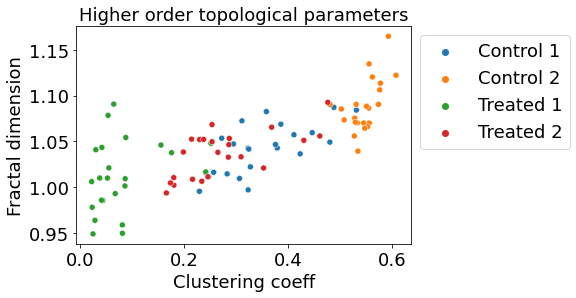

In [11]:
plt.figure()
sns.scatterplot(x = 'Clustering coeff', y = 'Fractal dimension', hue = 'Sample', data = data)
plt.legend(bbox_to_anchor=(1, 1))  
plt.title('Higher order topological parameters')

### Scatterplot with confidence ellipses
Visualize control and curaxin samples separately


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


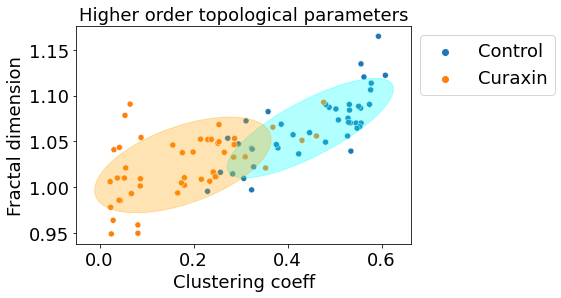

In [12]:
fig, ax = plt.subplots()


parameter1 = 'Clustering coeff'
parameter2 = 'Fractal dimension'

plt.title('Higher order topological parameters')

sns.scatterplot(x = parameter1, y = parameter2, hue = 'Specimen', data = data, ax =ax)
plt.legend(bbox_to_anchor=(1, 1))  

x1 = data[data['Specimen'] == 'Control'][parameter1]
y1=  data[data['Specimen'] == 'Control'][parameter2]

confidence_ellipse(x1, y1, ax, n_std=1.5, facecolor='cyan',alpha=0.3, edgecolor='cyan')

x2 = data[data['Specimen'] == 'Curaxin'][parameter1]
y2=  data[data['Specimen'] == 'Curaxin'][parameter2]

confidence_ellipse(x2, y2, ax, n_std=1.5, facecolor='orange',alpha=0.3, edgecolor='orange')

save_figures(plot = fig,path = path_figures, name_file = f'{parameter1}_{parameter2}', method= quantile_thresh)  

array([ 0.,  0.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.])